In [1]:
%matplotlib inline

In [2]:
import sys, os
import numpy as np
import SimpleITK as sitk
import matplotlib.pylab as plt
import glob
plt.rcParams['figure.figsize'] = (8,6)

In [3]:
dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/'

Aggregate the moving image data, sort it, and put it into a single itk object.

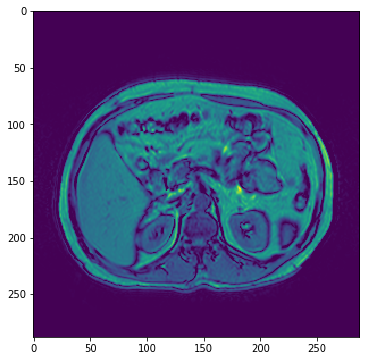

In [4]:
moving_img_list = []
#for i,fn in enumerate(sorted(glob.glob( dataRoot + '/1/T2SPIR/DICOM_anon/*dcm'))):
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/2/T1DUAL/DICOM_anon/*dcm'))):
    if i == 0:
        tmp_moving_image = sitk.ReadImage(fn)
    #print(sitk.ReadImage(fn).GetOrigin())
    #print(sitk.ReadImage(fn).GetSize())
    moving_img_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
plt.imshow(moving_img_list[20][0,:,:])
    
moving_image_series = np.zeros((len(moving_img_list),moving_img_list[0].shape[1], moving_img_list[0].shape[2] ), dtype=np.int16)
for i,img in enumerate(moving_img_list):
    moving_image_series[i,:,:] = img
    
moving_image = sitk.GetImageFromArray(moving_image_series)
moving_image.SetDirection(tmp_moving_image.GetDirection())
moving_image.SetOrigin(tmp_moving_image.GetOrigin())
moving_image.SetSpacing(tmp_moving_image.GetSpacing())

Do the same wrangling for the png segmentation images.

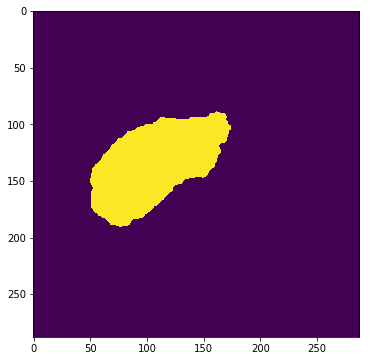

In [5]:
seg_image_list = []
#for i,fn in enumerate(sorted(glob.glob( dataRoot + '/2/T2SPIR/Ground/*png'))):
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/2/T1DUAL/Ground/*png'))):
    seg_image_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
    
plt.figure()
plt.imshow(seg_image_list[20][:,:])

seg_image= np.zeros((len(seg_image_list),seg_image_list[0].shape[0], seg_image_list[0].shape[1] ))
for i,img in enumerate(seg_image_list):
    seg_image[i,:,:] = img
    
    
seg_image= sitk.GetImageFromArray(seg_image)
seg_image.SetDirection(tmp_moving_image.GetDirection())
seg_image.SetOrigin(tmp_moving_image.GetOrigin())
seg_image.SetSpacing(tmp_moving_image.GetSpacing())

Now lets get the fixed images from the MRE dataset

In [6]:
temp_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/375/DICOM/ST00001'
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']

Reading Dicom directory: /pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/375/DICOM/ST00001
Image size: 512 512 4
Image dims: 0.6641 0.6641 9.199996948242188
(512, 512, 4)
(-192.97500610351562, -176.17799377441406, 103.55599975585938)


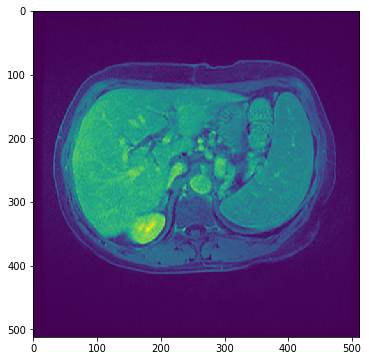

In [7]:
for fn in ['SE00003']:
    print( "Reading Dicom directory:", temp_data_dir )
    
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( temp_data_dir + '/' + fn )
    reader.SetFileNames(dicom_names)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    image = reader.Execute()
    size = image.GetSize()
    dims = image.GetSpacing()
    print( "Image size:", size[0], size[1], size[2] )
    print( "Image dims:", dims[0], dims[1], dims[2] )
fixed_image = image
fixed_image.GetPixelIDTypeAsString()
print(fixed_image.GetSize())
print(fixed_image.GetOrigin())
plt.imshow(sitk.GetArrayFromImage(fixed_image)[0])

Now let's interpolate everything so we're dealing with the same dimensions.

In [8]:
reference_origin = np.zeros(3)
reference_direction = np.identity(3).flatten()
reference_size = [300, 300, 4]
reference_spacing = [1.4,1.4,dims[2]] #1.4mm x 1.4mm x 11.5mm

reference_image = sitk.Image(reference_size, 2)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

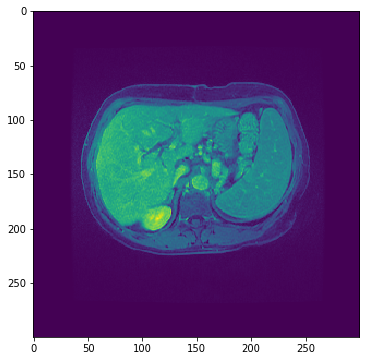

In [9]:
#for fixed:
transform = sitk.AffineTransform(3)
transform.SetMatrix(fixed_image.GetDirection())
transform.SetTranslation(np.array(fixed_image.GetOrigin()) - reference_origin)

centering_transform = sitk.TranslationTransform(3)
img_center = np.array(fixed_image.TransformContinuousIndexToPhysicalPoint(np.array(fixed_image.GetSize())/2.0))
centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
centered_transform = sitk.Transform(transform)
centered_transform.AddTransform(centering_transform)

#reference_image.SetSpacing([1.4,1.4,dims[-1]])
#reference_image.SetSpacing([1.3,1.3,15])
#reference_image.SetOrigin(image.GetOrigin())
new_fixed_image = sitk.Resample(fixed_image, reference_image, centered_transform, sitk.sitkNearestNeighbor)
new_fixed_image = sitk.Normalize(new_fixed_image)

plt.imshow(sitk.GetArrayFromImage(new_fixed_image)[0])

In [10]:
new_fixed_image.GetSize()

(300, 300, 4)

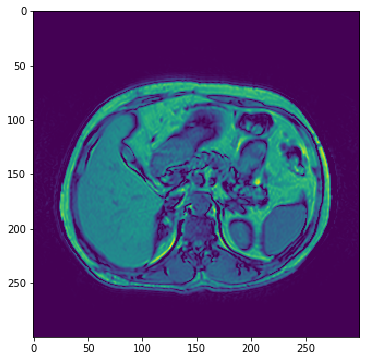

In [11]:
#for moving:
transform = sitk.AffineTransform(3)
transform.SetMatrix(moving_image.GetDirection())
transform.SetTranslation(np.array(moving_image.GetOrigin()) - reference_origin)

centering_transform = sitk.TranslationTransform(3)
img_center = np.array(moving_image.TransformContinuousIndexToPhysicalPoint(np.array(moving_image.GetSize())/2.0))
centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
centered_transform = sitk.Transform(transform)
centered_transform.AddTransform(centering_transform)

#reference_image.SetSpacing([1.4,1.4,dims[-1]])
#reference_image.SetSpacing([1.3,1.3,15])
#reference_image.SetOrigin(image.GetOrigin())
new_moving_image = sitk.Resample(moving_image, reference_image, centered_transform, sitk.sitkNearestNeighbor)
new_moving_image = sitk.Normalize(new_moving_image)

plt.imshow(sitk.GetArrayFromImage(new_moving_image)[0])

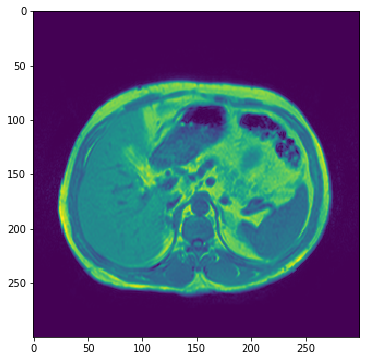

In [12]:
plt.imshow(sitk.GetArrayFromImage(new_moving_image)[3])

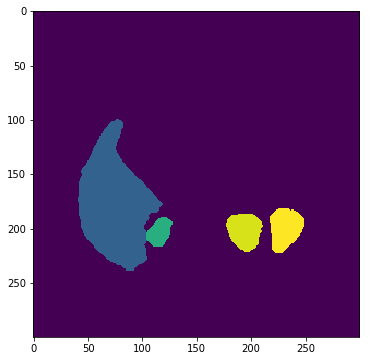

In [13]:
#for seg:
transform = sitk.AffineTransform(3)
transform.SetMatrix(seg_image.GetDirection())
transform.SetTranslation(np.array(seg_image.GetOrigin()) - reference_origin)

centering_transform = sitk.TranslationTransform(3)
img_center = np.array(seg_image.TransformContinuousIndexToPhysicalPoint(np.array(seg_image.GetSize())/2.0))
centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
centered_transform = sitk.Transform(transform)
centered_transform.AddTransform(centering_transform)

#reference_image.SetSpacing([1.4,1.4,dims[-1]])
#reference_image.SetSpacing([1.3,1.3,15])
#reference_image.SetOrigin(image.GetOrigin())
new_seg_image = sitk.Resample(seg_image, reference_image, centered_transform, sitk.sitkNearestNeighbor)

plt.imshow(sitk.GetArrayFromImage(new_seg_image)[0])

# Registration

Going to copy and paste in some methods from simpleITK notebook, attempt basic registration.

In [14]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img));
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [35]:
# initial_transform = sitk.CenteredTransformInitializer(new_fixed_image, 
#                                                       new_moving_image, 
#                                                       sitk.Euler3DTransform(), 
#                                                       #sitk.BSplineTransform(3), 
#                                                       sitk.CenteredTransformInitializerFilter.GEOMETRY)
#transformDomainMeshSize=[3]*new_moving_image.GetDimension()
#initial_transform = sitk.BSplineTransformInitializer(new_fixed_image,
#                                      transformDomainMeshSize )
affine = sitk.AffineTransform(new_moving_image.GetDimension())
transformDomainMeshSize=[3]*new_moving_image.GetDimension()
bspline = sitk.BSplineTransformInitializer(new_fixed_image, transformDomainMeshSize)
initial_transform = sitk.Transform(new_moving_image.GetDimension(), sitk.sitkComposite)
initial_transform.AddTransform(affine)
initial_transform.AddTransform(bspline)


moving_resampled = sitk.Resample(new_moving_image, new_fixed_image, initial_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,new_fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(new_fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

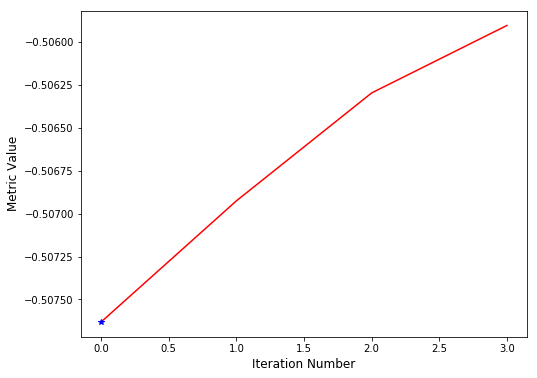

In [36]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=3)
#registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsJointHistogramMutualInformation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.1)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
#registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerAsGradientDescentLineSearch(5.0,
                                          100,
                                          convergenceMinimumValue=1e-4,
                                          convergenceWindowSize=5)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
#registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
#registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1])
#registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=True,)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

#final_transform = registration_method.Execute(sitk.Cast(new_fixed_image, sitk.sitkFloat32), 
#                                              sitk.Cast(new_moving_image, sitk.sitkFloat32))
final_transform = registration_method.Execute(new_fixed_image, new_moving_image)

In [37]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.5076308878098023
Optimizer's stopping condition, GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 4.


In [38]:
moving_resampled = sitk.Resample(new_moving_image, new_fixed_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,new_fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(new_fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))